# Procent taboru przebywający na zajezdniach

to install:
* pip install psycopg2

In [2]:
import requests
import json
import psycopg2
import datetime as dt

## Dane zajezdni

In [2]:
# nazwa, latitude, longitude, distance
zajezdnie_busy = [
    ("REDUTOWA", 52.23061857379436, 20.936765670776367, 0.06236855301703596),
    ("REDUTOWA drugi plac", 52.23193937500522, 20.940263271331787, 0.13665252960668017),
    ("WORONICZA", 52.18722057122196, 20.996503829956055, 0.20439303090875055),
    ("OSTROBRAMSKA", 52.23395007154719, 21.11621618270874, 0.204),
    ("KLESZCZOWA", 52.19667825460031, 20.920822620391846, 0.18329678588884157),
    ("STALOWA", 52.26532090489898, 21.045405864715576, 0.2419510558485915),
    ("PKS GRODZ MAZOWIECKI", 52.268157373768176, 21.077635288238525, 0.11347165678982334),
    ("MOBILIS (URSUS)", 52.20688345506539, 20.88272452354431, 0.15629660391492434),
    ("MOBILIS (UTRATA)", 52.26227412509487, 21.101356744766235, 0.17043508719298783),
    ("ITS MICHALCZEWSKI", 52.31847450379307, 21.015515327453613, 0.170)
]
zajezdnie_busy = [(x[0], x[1], x[2], x[3]*1000/111195) for x in zajezdnie_busy] # przeliczenie kilometrow na stopnie

## Dane używając bezpośrednio postgresql

In [6]:
DB_NAME = "history"
PORT = 5432
USER = "reader_user@tramwaje"
PASSWORD = "wgm5bvho"
HOST = "tramwaje.postgres.database.azure.com"

In [173]:
def get_buses():
    """
    Funkcja zbierajaca dane z okresu 24 godzin o autobusach, ktore znajduja sie w zajezdniach
    """
    conn = psycopg2.connect(dbname=DB_NAME, port=PORT, user=USER,password=PASSWORD, host=HOST)
    cur = conn.cursor()
    by_hour = {}
    query = """
        select distinct on (date_trunc('hour', chunktime)) chunktime
        from log_l
        where collection='Buses'
        order by date_trunc('hour', chunktime), chunktime
        LIMIT 24
    """
    cur.execute(query)
    d = cur.fetchall()
    sec = dt.timedelta(seconds=1)
    chunks = [((val[0] - sec).strftime("%Y-%m-%d %H:%M:%S.%f"), (val[0] + sec).strftime("%Y-%m-%d %H:%M:%S.%f"), val[0].strftime("%Y-%m-%d %H:%M:%S.%f")) for val in d]

    for chunk in chunks:
        by_stop = {}
        print(chunk)
        for i in range(len(zajezdnie_busy)):
            print(i)                                 
            print("%s Begin getting data for stop %s at %s" % 
                  (dt.datetime.now(), zajezdnie_busy[i][0], chunk[0]))
            query = """
                SELECT
                    lines
                FROM
                    buses_l
                WHERE
                    st_intersects(geom, st_Buffer(st_GeomFromText('POINT(%s %s)', 4326), %s, 'quad_segs=8')) and
                    chunktime >= to_timestamp('%s', 'yyyy-mm-dd hh24:mi:ss') and
                    chunktime <= to_timestamp('%s', 'yyyy-mm-dd hh24:mi:ss')
            """ % (zajezdnie_busy[i][2], zajezdnie_busy[i][1], zajezdnie_busy[i][3], chunk[0], chunk[1])
            
            cur.execute(query)
            buses = cur.fetchall()
            by_stop[i] = buses
            print("%s Finished getting data for stop %s at %s" %
                  (dt.datetime.now(), zajezdnie_busy[i][0], chunk))
        by_hour[chunk[2]] = by_stop
    conn.commit()
    cur.close()
    conn.close()
    return by_hour

In [ ]:
by_hour = get_buses()

### Zapisywanie do danych pliku json

In [175]:
json.dump(by_hour, open("data.txt",'w'))

In [170]:
d2 = json.load(open("data.txt"))

# Analiza danych

Przeglądając przetworzone przez nasz system dane - tj. wyświetlanie pojedyńczych punktów oznaczających ciężko jest dostrzec wzorce czy wysnuwać wnioski. Dlatego przedstawiliśmy mapę ciepła dla autobusów (slajd 5 w prezentacji). Dzięki niej udało się wyróżnić punkty, w których jest w danym momencie dużo pojazdów. Widać wyraźnie kilka takich punktów. Poza oczywistym, jakim jest `Dworzec Centralny` - centralny hub przesiadkowy w mieście - wyróżniamy kilka innych punktów. Okazuje się, że wskazują one na zajezdnie autobusowe. 

Dla m. st Warszawy, a dokładniej dla spółki `ZTM`, pracuje kilka przewoźników: `MZA`, `Mobilis`, `Arriva` oraz `PKS Grodzisk Mazowiecki`. Badając mapę ciepła można stwierdzić, że przewoźnicy `Mobilis` oraz `PKS Grodzisk Mazowiecki` nie udostępniają swoich danych poprzez API. Przewoźnik `Arriva (grupa Deutsche Bahn)` udostępnia dane. Wskazuje na to lokalizacja autobusów linii $103$, $118$, $153$, $157$, $176$, $304$, $326$ i $516$ w zajezdni `ITS Michalczewski`. Dawny przewoźnik, `ITS Michalczewski`, nie wykonuje już usług na rzecz miasta a jedynie wynajmuje bazę dla niemieckiego przewoźnika.

Zgodnie z wykresem sumy autobusów w zajezdniach dla firm `Arriva` oraz `MZA` (slajd 11 z prezentacji) widać wyraźnie dużą ilość autobusów przed porannym szczytem oraz między szczytami porannym i popołudniowym. Na co warto zwrócić uwagę, nie widać takich danych w nocy. Wnioskujemy, że podczas konserwacji autobusów w nocy systemy odpowiadające za lokalizację autobusów są wyłączone. Przykładowo dla godziny $11$ mamy $127$ autobusów stacjonujących w zajezdniach, przy ogólnej liczbie $1166$ co stanowi około $10$% taboru.

## Wykresy

In [8]:
import matplotlib.pyplot as plt

In [8]:
conn = psycopg2.connect(dbname=DB_NAME, port=PORT, user=USER,password=PASSWORD, host=HOST)
cur = conn.cursor()
query = """
        select distinct on (date_trunc('hour', chunktime)) chunktime
        from log_l
        where collection='Buses'
        order by date_trunc('hour', chunktime), chunktime
        LIMIT 24
"""
cur.execute(query)
d = cur.fetchall()
conn.commit()
cur.close()
conn.close()
chunks = [val[0].strftime("%H") for val in d]

In [157]:
hours = [int(val) for val in chunks]

In [201]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., height,
                '%d' % int(height),
                ha='center', va='bottom')

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


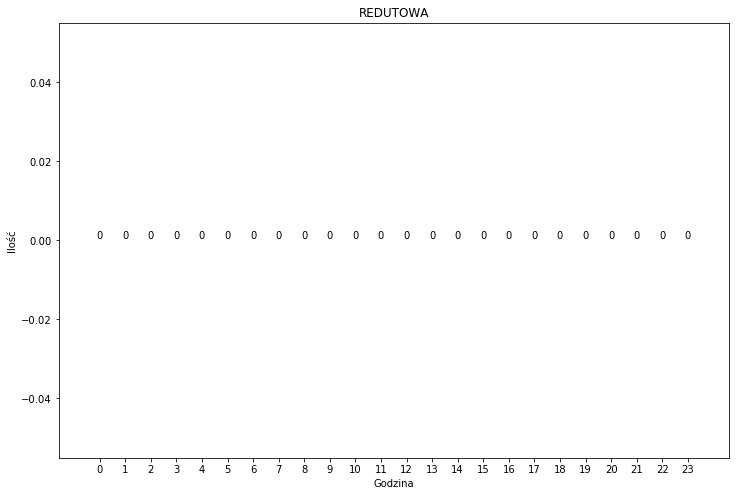

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


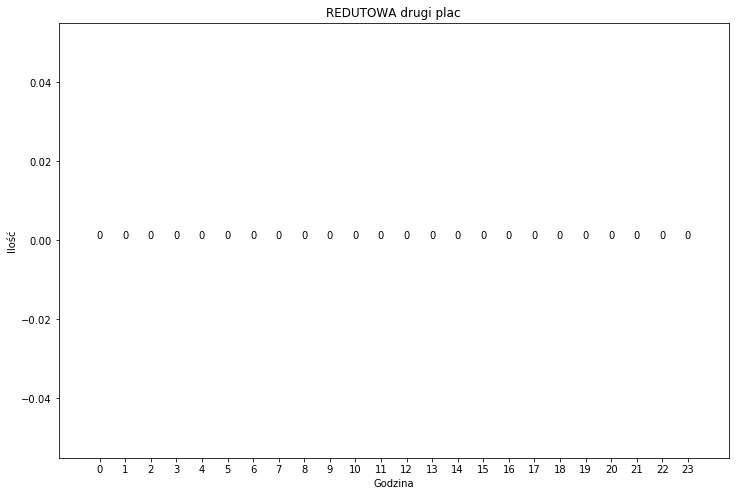

[12, 14, 15, 45, 37, 22, 5, 2, 3, 4, 6, 4, 5, 8, 8, 1, 1, 1, 10, 28, 31, 0, 1, 1]


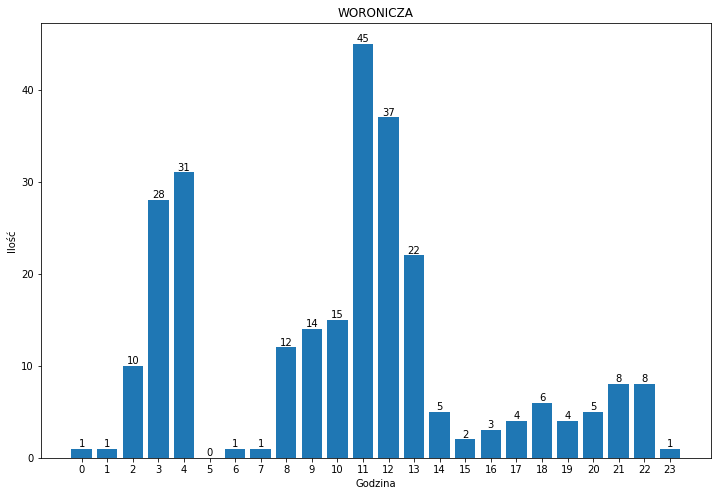

[27, 27, 30, 72, 68, 40, 9, 3, 5, 7, 8, 6, 7, 12, 16, 1, 2, 2, 24, 51, 60, 2, 3, 10]


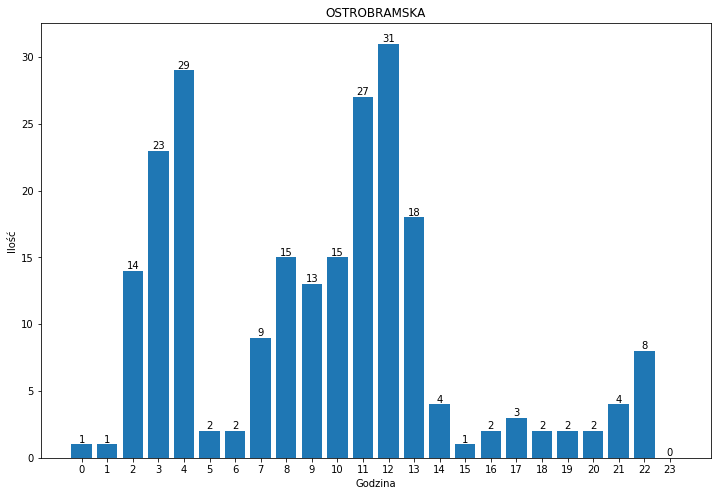

[48, 58, 55, 107, 97, 52, 10, 3, 5, 8, 8, 7, 7, 14, 17, 2, 2, 2, 36, 72, 81, 2, 3, 10]


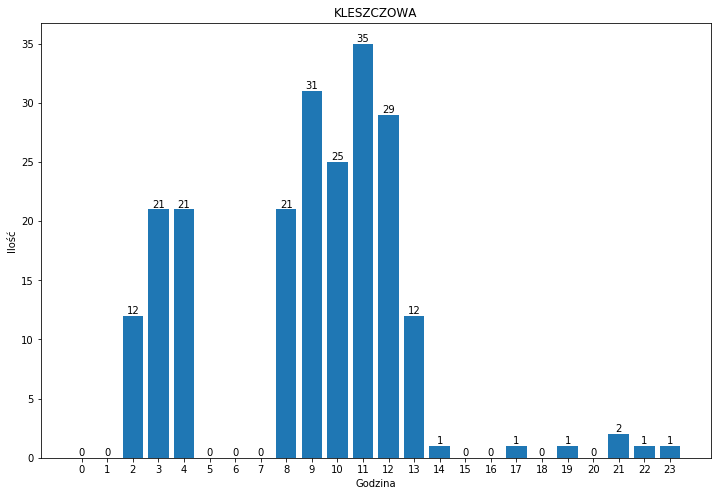

[58, 67, 64, 118, 111, 59, 10, 3, 5, 9, 9, 8, 9, 15, 18, 2, 2, 2, 49, 97, 99, 2, 3, 13]


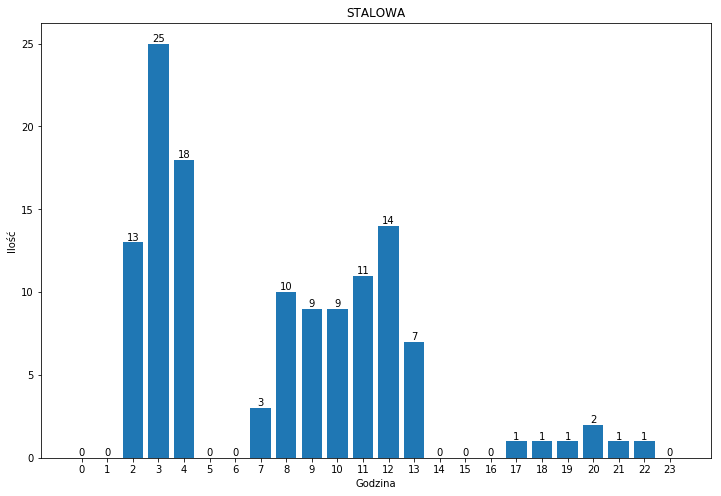

[58, 67, 64, 118, 111, 59, 10, 3, 5, 9, 9, 8, 9, 15, 18, 2, 2, 2, 49, 97, 99, 2, 3, 13]


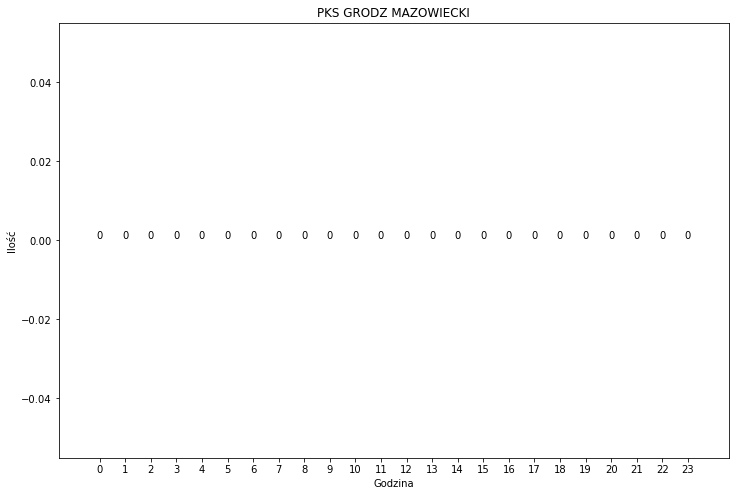

[58, 67, 64, 118, 112, 59, 10, 3, 5, 9, 9, 8, 9, 15, 18, 2, 2, 2, 49, 97, 99, 2, 3, 13]


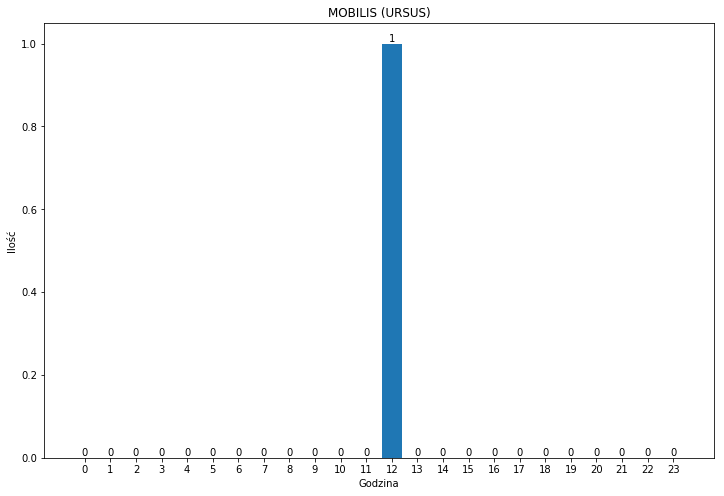

[58, 67, 64, 118, 112, 59, 10, 3, 5, 9, 9, 8, 9, 15, 18, 2, 2, 2, 49, 97, 99, 2, 3, 13]


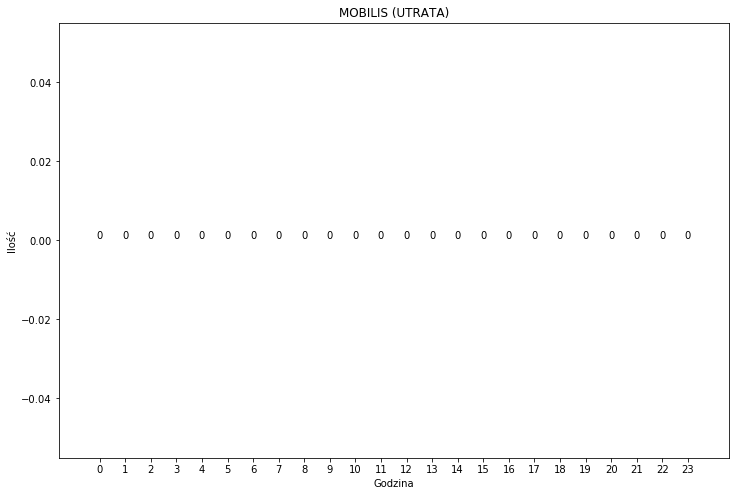

[64, 77, 74, 127, 119, 59, 10, 3, 5, 9, 9, 9, 9, 15, 18, 2, 2, 2, 49, 97, 100, 2, 3, 14]


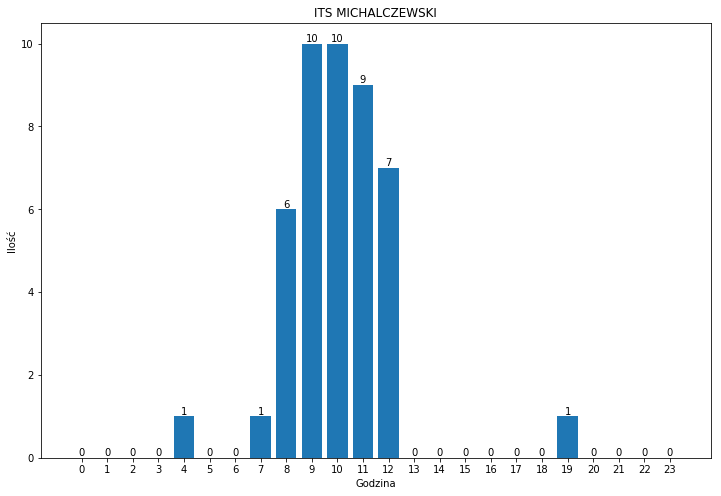

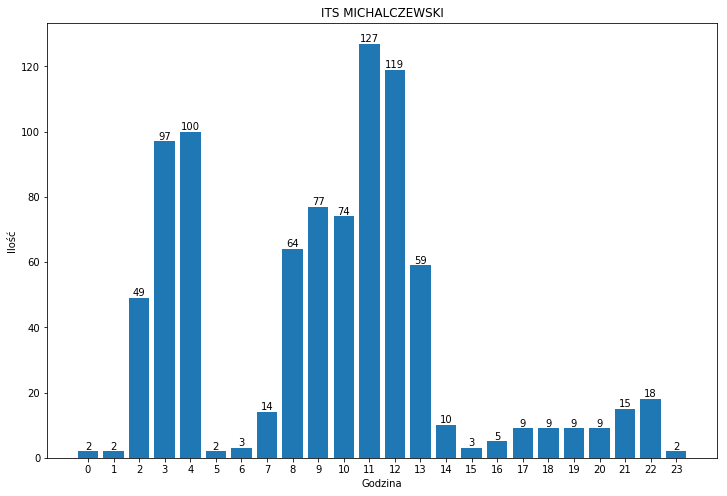

In [216]:
count_sum = [0 for x in range(24)]
for i in range(10):
    count = [len(val[i]) for val in by_hour.values()]
    for val in range(24):
        count_sum[val] += count[val]
    print(count_sum)
    plt.rcParams["figure.figsize"] = [12, 8]
    rects = plt.bar(hours, count, align='center')
    autolabel(rects)
    plt.xticks(hours)
    plt.ylabel('Ilość')
    plt.xlabel('Godzina')
    plt.title(zajezdnie_busy[i][0])  
    plt.savefig("./wykresy/" + zajezdnie_busy[i][0].replace(" ", "_").lower() + ".png")
    plt.show()

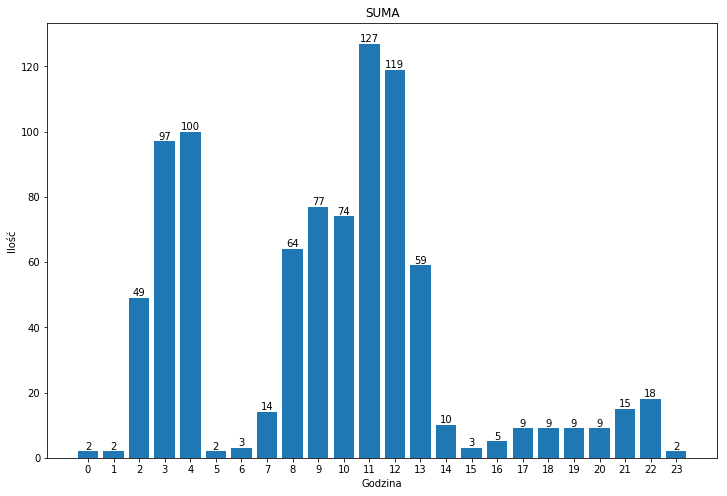

In [217]:
plt.rcParams["figure.figsize"] = [12, 8]
rects = plt.bar(hours, count_sum, align='center')
autolabel(rects)
plt.xticks(hours)
plt.ylabel('Ilość')
plt.xlabel('Godzina')
plt.title('SUMA')  
plt.savefig("./wykresy/suma.png")
plt.show()